In [14]:
# torch
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from tqdm.notebook import tnrange, tqdm_notebook
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# standard libraries
from PIL import Image
import matplotlib.pyplot as plt
import math
import random
import os
import json
import cv2
import pandas as pd
import numpy as np
import sys
import json

sys.path.append("../")

from dataset import TreeDataset
from transforms import MaskResize
from visualize import BatchVisualizer as BV
import utils

In [20]:
class CV2ToTensorTransform:
    def __init__(self, size=(255, 255)):
        self.size = size
        self.transform = T.Compose([
            T.Resize(self.size),  # resize first
            T.ToTensor()          # then convert to [C,H,W]
        ])
        
    def __call__(self, img):
        # img: cv2 NumPy array (H,W,3)
        img = Image.fromarray(img)  # convert to PIL
        img = self.transform(img)
        return img

In [21]:
data_configs = {
    'root': '../data/Some Trees Dataset.v12i.coco-segmentation',
    'seed': 42,
    'transforms': {
        'image_transforms': CV2ToTensorTransform(size=(255, 255)),
        'mask_transforms': MaskResize(size=(255, 255)),
    },
    'batch_size': 4
}

In [22]:
utils.set_seed(data_configs['seed'])
train_set = TreeDataset(data_configs['root'], 
                        'train', 
                        data_configs['transforms']['image_transforms'], 
                        data_configs['transforms']['mask_transforms']
)

val_set = TreeDataset(data_configs['root'], 
                        'valid', 
                        data_configs['transforms']['image_transforms'], 
                        data_configs['transforms']['mask_transforms']
)

test_set = TreeDataset(data_configs['root'], 
                        'test', 
                        data_configs['transforms']['image_transforms'], 
                        data_configs['transforms']['mask_transforms']
)

In [31]:
utils.set_seed(data_configs['seed'])

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)
    
train_loader = DataLoader(train_set, batch_size=data_configs['batch_size'], shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=data_configs['batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=data_configs['batch_size'], shuffle=True, collate_fn=collate_fn)

In [32]:
x, y = next(iter(train_loader))

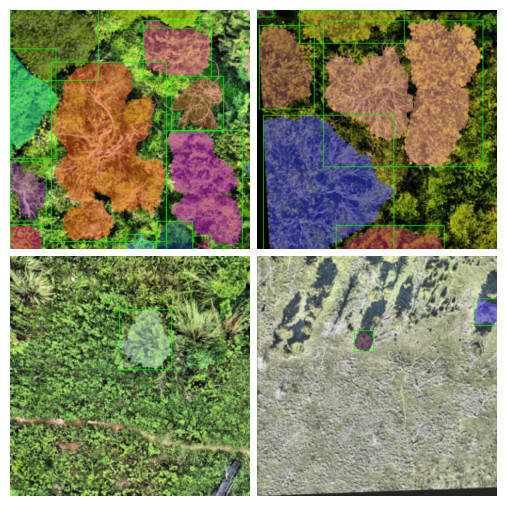

In [33]:
bv = BV(m=2, n=2, figsize=(5, 5))
f = bv.visualize_batch((x,y))

In [34]:
from models.resnets import TreeMaskRCNN

model = TreeMaskRCNN(backbone_variant='resnet50', pretrained=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TreeMaskRCNN(
  (model): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BottleneckFPNBackbone(
      (body): ModuleDict(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1

```python

model.train()
for batch in train_loader:
    images, targets = batch
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
    loss_dict = model(images, targets)
    break


loss_dict = {'loss_classifier': tensor(0.7170, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0126, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_mask': tensor(6.2909, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.6555, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.4025, device='cuda:0', grad_fn=<DivBackward0>)}


```

```python
model.eval()
with torch.no_grad():
    y_pred = model(images)


y_pred.kyes() = dict_keys(['boxes', 'labels', 'scores', 'masks'])
```

In [35]:
class LitInstanceSeg(pl.LightningModule):
    """
    A complete, production-grade Lightning module for Mask R-CNN instance segmentation.
    """

    def __init__(
        self,
        model,
        lr=1e-4,
        weight_decay=1e-4,
        scheduler_patience=2,
        scheduler_factor=0.5,
        visualizer=None,         # BV instance
        save_visuals=True,
        num_visuals=2
    ):
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        self.scheduler_patience = scheduler_patience
        self.scheduler_factor = scheduler_factor
        self.visualizer = visualizer
        self.save_visuals = save_visuals
        self.num_visuals = num_visuals

        self.example_input_array = [torch.randn(3, 255, 255)]

    # ----------------------------------------------------------
    # Utility to normalize losses returned by Mask R-CNN
    # ----------------------------------------------------------
    def _compute_loss(self, loss_dict):
        if isinstance(loss_dict, dict):
            return sum(loss_dict.values())
        elif isinstance(loss_dict, list):
            total = 0
            for d in loss_dict:
                total += sum(d.values())
            return total
        else:
            raise TypeError(f"Unexpected loss_dict type: {type(loss_dict)}")

    # ----------------------------------------------------------
    # FORWARD (inference only)
    # ----------------------------------------------------------
    def forward(self, images):
        self.model.eval()
        with torch.no_grad():
            return self.model(images)

    # ----------------------------------------------------------
    # TRAINING STEP
    # ----------------------------------------------------------
    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)
        loss = self._compute_loss(loss_dict)

        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    # ----------------------------------------------------------
    # VALIDATION STEP
    # ----------------------------------------------------------
    def validation_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)
        loss = self._compute_loss(loss_dict)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return {"images": images, "preds": None, "targets": targets}

    # ----------------------------------------------------------
    # TEST STEP (same as val if needed)
    # ----------------------------------------------------------
    def test_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)
        loss = self._compute_loss(loss_dict)

        self.log("test_loss", loss)
        return loss

    # ----------------------------------------------------------
    # PREDICT STEP
    # ----------------------------------------------------------
    def predict_step(self, batch, batch_idx):
        images, _ = batch
        return self.model(images)

    # ----------------------------------------------------------
    # VISUALIZATION AT END OF VALIDATION EPOCH
    # ----------------------------------------------------------
    def on_validation_epoch_end(self):
        if not self.save_visuals or self.visualizer is None:
            return
    
        # ---- STEP 1: GET BATCH FROM VAL LOADER ----
        val_loader = self.trainer.val_dataloaders[0]
        x, y = next(iter(val_loader))   # x = list[tensors], y = list[dict]
    
        # Limit number of visuals
        x = x[:self.num_visuals]
        y = y[:self.num_visuals]
    
        # ---- STEP 2: PREDICT ----
        self.model.eval()
        with torch.no_grad():
            raw_preds = self.model(x)
    
        # ---- STEP 3: POSTPROCESS PREDICTIONS TO MATCH YOUR FORMAT ----
        processed_preds = []
        for pred in raw_preds:
            ppred = self.prediction_processor(pred)
    
            # Ensure mask format becomes (C, H, W)
            if ppred["masks"].ndim == 4:     # (C,1,H,W)
                ppred["masks"] = ppred["masks"][:, 0, :, :]
    
            processed_preds.append(ppred)
    
        # ---- STEP 4: VISUALIZE USING YOUR BV CLASS ----
        bv = self.visualizer  # already BV(...)
        fig = bv.visualize_batch((x, processed_preds))
    
        # ---- STEP 5: SAVE ONE EXAMPLE IMAGE ----
        # fig is expected to be a list of figs; fig[0] for the first image
        try:
            pil_img = Image.fromarray(bv.fig_to_image(fig[0]))
            pil_img.save(f"val_batch_epoch_{self.current_epoch}.png")
        except Exception as e:
            print("❗ Error saving validation visual:", e)
    
        # ---- OPTIONAL: TensorBoard Logging ----
        try:
            self.logger.experiment.add_image(
                f"val_examples/epoch_{self.current_epoch}",
                torch.tensor(bv.fig_to_image(fig[0])).permute(2,0,1),
                self.current_epoch
            )
        except:
            pass

    # ----------------------------------------------------------
    # OPTIMIZER + LR SCHEDULER
    # ----------------------------------------------------------
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=self.scheduler_patience,
            factor=self.scheduler_factor
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

    # ----------------------------------------------------------
    # GRADIENT DIAGNOSTICS
    # ----------------------------------------------------------
    def on_before_backward(self, loss):
        if torch.isnan(loss):
            print("⚠ NaN loss detected — check learning rate or data.")

    def on_after_backward(self):
        # custom gradient clipping (you can disable Lightning clip_grad)
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

    # ----------------------------------------------------------
    # TRAINING START / END HOOKS
    # ----------------------------------------------------------
    def on_fit_start(self):
        print("🚀 Training started!")
        print("Parameters:", sum(p.numel() for p in self.model.parameters()))

    def on_fit_end(self):
        print("🏁 Training complete!")

In [36]:
class PredictionProcessor:
    def __init__(self, mask_threshold=0.5, score_threshold=0.5):
        self.mask_threshold = mask_threshold
        self.score_threshold = score_threshold

    def __call__(self, prediction):
        # Handle empty predictions
        if not prediction or "masks" not in prediction or "scores" not in prediction:
            return {
                "boxes": torch.empty((0, 4)),
                "labels": torch.empty((0,), dtype=torch.int64),
                "scores": torch.empty((0,)),
                "masks": torch.empty((0, 1, 1, 1))
            }

        keep = prediction["scores"] >= self.score_threshold
        prediction = {k: v[keep] for k, v in prediction.items()}

        if "masks" in prediction and len(prediction["masks"]) > 0:
            prediction["masks"] = (prediction["masks"] > self.mask_threshold).float()

        return prediction
        
processor = PredictionProcessor(mask_threshold=0.5, score_threshold=0.5)

In [37]:
segmentor = LitInstanceSeg(model, visualizer=bv)

In [38]:
checkpoint_cb = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best_instance_seg"
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

In [39]:
logger = CSVLogger("logs", name="instance_seg")

In [40]:
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="gpu",  # or "cpu"
    devices=1,
    log_every_n_steps=10,
    callbacks=[checkpoint_cb, lr_monitor],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [41]:
trainer.fit(segmentor, train_dataloaders=val_loader, val_dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([255, 255])

In [39]:
xt, yt = next(iter(test_loader))

In [41]:
def predict(images):
    image_batch = [image.to(device) for image in images]
    segmentor.eval()
    with torch.no_grad():
        y_p = segmentor(x)
    return y_p